<a href="https://colab.research.google.com/github/t2222/hvd/blob/main/1607015_Data_mining_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# package installation

In [ ]:
!pip install metis
!wget http://glaros.dtc.umn.edu/gkhome/fetch/sw/metis/OLD/metis-5.0.3.tar.gz
!tar -xf metis-5.0.3.tar.gz
!mv metis-5.0.3/* ../content/
!make config shared=1
!make install
%env METIS_DLL=/usr/local/lib/libmetis.so

# imports

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
from sklearn import *
import pandas as pd
from sklearn.cluster import *
import random
from sklearn.metrics.pairwise import pairwise_distances
import random
import matplotlib.pyplot as plt
import metis
import os
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn import datasets
from sklearn.cluster import KMeans, MeanShift, DBSCAN, Birch
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
import networkx as nx
import itertools
from scipy.special import comb
from tqdm import tqdm

# Upload cereal dataset attached with submission

In [ ]:
# from google.colab import files 

# uploaded = files.upload()

# K means Clustering 

In [34]:
df = pd.read_csv('cereal.csv')
df.head()

,serial,calories,sodium
0,1,70,130
1,2,120,15
2,3,70,260
3,4,50,140
4,5,110,200


array([0, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 2, 1,
       0, 0, 0, 1, 2, 0, 1, 0, 2, 1, 0, 0, 2, 1, 1, 0, 0, 0, 1, 0, 0, 2,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 2, 2, 0, 2, 1, 0, 2, 1, 1, 2, 2, 2,
       2, 1, 2, 1, 0, 1, 1, 0, 1, 1, 1], dtype=int32)

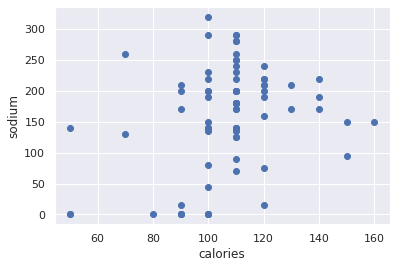

In [35]:
plt.scatter(df.calories,df['sodium'])
plt.xlabel("calories")
plt.ylabel("sodium")
number_of_clusters = 3
km = KMeans(n_clusters=number_of_clusters, n_init=10, max_iter=300, precompute_distances=True)
y_predicted = km.fit_predict(df[['calories','sodium']])
df['cluster'] = y_predicted
df.head()
km.labels_


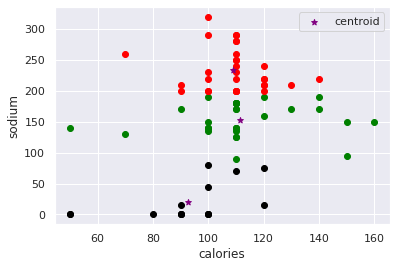

In [36]:
df1 = df[df.cluster==0]
df2 = df[df.cluster==1]
df3 = df[df.cluster==2]
plt.scatter(df1.calories,df1['sodium'],color='green')
plt.scatter(df2.calories,df2['sodium'],color='red')
plt.scatter(df3.calories,df3['sodium'],color='black')
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='purple',marker='*',label='centroid')
plt.xlabel('calories')
plt.ylabel('sodium')
plt.legend()


# BIRCH

No handles with labels found to put in legend.


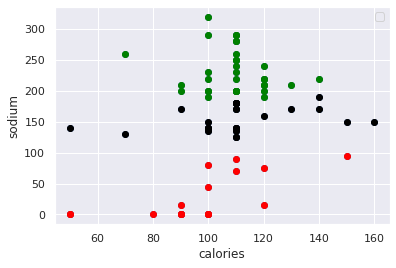

In [37]:
#Birch
plt.scatter(df.calories,df['sodium'])
plt.xlabel("calories")
plt.ylabel("sodium")
bir = Birch(threshold=0.5, branching_factor=50, n_clusters=3, compute_labels=True, copy=True)
y_predicted = bir.fit_predict(df[['calories','sodium']])
df['bi_cluster'] = y_predicted
df.head()
df1 = df[df.bi_cluster==0]
df2 = df[df.bi_cluster==1]
df3 = df[df.bi_cluster==2]
plt.scatter(df1.calories,df1['sodium'],color='green')
plt.scatter(df2.calories,df2['sodium'],color='red')
plt.scatter(df3.calories,df3['sodium'],color='black')
plt.xlabel('calories')
plt.ylabel('sodium')
plt.legend()

# CHAMELEON

In [54]:
class Chameleon():
    def __init__(self):
        self.cmap = plt.get_cmap('viridis')
        self.colors = [self.cmap(i) for i in np.linspace(0, 1, 10)]

    def plot2d_graph(self, graph):
        pos = nx.get_node_attributes(graph, 'pos')
        c = [self.colors[i % (len(self.colors))]
             for i in nx.get_node_attributes(graph, 'cluster').values()]
        if c:  # is set
            nx.draw(graph, pos, node_color=c, node_size=0.25)
        else:
            nx.draw(graph, pos, node_size=0.25)
        plt.show(block=False)

    def plot2d_data(self, df):
        if (len(df.columns) > 3):
            print("Plot Waring: more than 2-Dimensions!")
        df.plot(kind='scatter', c=df['cluster'], cmap='gist_rainbow', x=0, y=1)
        plt.show(block=False)

    def euclidean_distance(self, a, b):
        return np.linalg.norm(np.array(a) - np.array(b))

    def knn_graph(self, df, k, verbose=False):
        points = [p[1:] for p in df.itertuples()]
        g = nx.Graph()
        for i in range(0, len(points)):
            g.add_node(i)
        if verbose:
            print("Building kNN graph (k = %d)..." % (k))
        iterpoints = tqdm(enumerate(points), total=len(
            points)) if verbose else enumerate(points)
        for i, p in iterpoints:
            distances = list(
                map(lambda x: self.euclidean_distance(p, x), points))
            # second trough kth closest
            closests = np.argsort(distances)[1:k+1]
            # print(distances[0])
            for c in closests:
                g.add_edge(i, c, weight=1.0 / distances[c], similarity=int(
                    1.0 / distances[c] * 1e4))
            g.nodes[i]['pos'] = p
        g.graph['edge_weight_attr'] = 'similarity'
        return g

    def part_graph(self, graph, k, df=None):
        
        edgecuts, parts = metis.part_graph(
            graph, 2 , objtype='cut')
        # print(edgecuts)
        for i, p in enumerate(graph.nodes()):
            graph.nodes[p]['cluster'] = parts[i]
        if df is not None:
            df['cluster'] = nx.get_node_attributes(graph, 'cluster').values()
        return graph

    def pre_part_graph(self, graph, k, df=None, verbose=False):
        if verbose:
            print("Begin clustering...")
        clusters = 0
        for i, p in enumerate(graph.nodes()):
            graph.nodes[p]['cluster'] = 0
        cnts = {}
        cnts[0] = len(graph.nodes())
        while clusters < k - 1:
            maxc = -1
            maxcnt = 0
            for key, val in cnts.items():
                if val > maxcnt:
                    maxcnt = val
                    maxc = key
            s_nodes = [n for n in graph.nodes if graph.nodes[n]
                       ['cluster'] == maxc]
            s_graph = graph.subgraph(s_nodes)
            edgecuts, parts = metis.part_graph(
                s_graph, 2 , objtype='cut')
            new_part_cnt = 0
            for i, p in enumerate(s_graph.nodes()):
                if parts[i] == 1:
                    graph.nodes[p]['cluster'] = clusters + 1
                    new_part_cnt = new_part_cnt + 1
            cnts[maxc] = cnts[maxc] - new_part_cnt
            cnts[clusters + 1] = new_part_cnt
            clusters = clusters + 1
        
        edgecuts, parts = metis.part_graph(graph, k)
        if df is not None:
            df['cluster'] = nx.get_node_attributes(graph, 'cluster').values()
        return graph

    def get_cluster(self, graph, clusters):
        nodes = [n for n in graph.nodes if graph.nodes[n]['cluster'] in clusters]
        return nodes

    def connecting_edges(self, partitions, graph):
        cut_set = []
        for a in partitions[0]:
            for b in partitions[1]:
                if a in graph:
                    if b in graph[a]:
                        cut_set.append((a, b))
        return cut_set

    def min_cut_bisector(self, graph):
        graph = graph.copy()
        graph = self.part_graph(graph, 2)
        partitions = self.get_cluster(graph, [0]), self.get_cluster(graph, [1])
        return self.connecting_edges(partitions, graph)

    def get_weights(self, graph, edges):
        return [graph[edge[0]][edge[1]]['weight'] for edge in edges]

    def bisection_weights(self, graph, cluster):
        cluster = graph.subgraph(cluster)
        edges = self.min_cut_bisector(cluster)
        weights = self.get_weights(cluster, edges)
        return weights


    def external_index(self , v1, v2):
        TP, FN, FP, TN = self.confusion_index(v1, v2)
        RI = (TP + TN) / (TP + FN + FP + TN)
        ARI = 2 * (TP * TN - FN * FP) / ((TP + FN) *
                                        (FN + TN) + (TP + FP) * (FP + TN))
        JI = TP / (TP + FN + FP)
        FM = TP / np.sqrt((TP + FN) * (TP + FP))
        return RI, ARI, JI, FM


    def confusion_index(self , v1, v2):
        cmatrix = self.contingency(v1, v2)
        size = np.size(v1)
        sum_rows = np.sum(cmatrix, 0)
        sum_cols = np.sum(cmatrix, 1)
        N = comb(size, 2)
        TP = np.sum(list(map(lambda x: comb(x, 2), cmatrix)))
        FN = np.sum(list(map(lambda x: comb(x, 2), sum_rows))) - TP
        FP = np.sum(list(map(lambda x: comb(x, 2), sum_cols))) - TP
        TN = N - TP - FN - FP
        return TP, FN, FP, TN


    def contingency(self , v1, v2):
        res = np.zeros((np.max(v1), np.max(v2)))
        for i in range(0, np.size(v1)):
            res[v1[i] - 1, v2[i] - 1] = res[v1[i] - 1, v2[i] - 1] + 1
        return res


    def internal_interconnectivity(self , graph, cluster):
        return np.sum(self.bisection_weights(graph, cluster))


    def relative_interconnectivity(self , graph, cluster_i, cluster_j):
        edges = self.connecting_edges((cluster_i, cluster_j), graph)
        EC = np.sum(self.get_weights(graph, edges))
        ECci, ECcj = self.internal_interconnectivity(graph, cluster_i), self.internal_interconnectivity(graph, cluster_j)
        return EC / ((ECci + ECcj) / 2.0)


    def internal_closeness(self , graph, cluster):
        cluster = graph.subgraph(cluster)
        edges = cluster.edges()
        weights = self.get_weights(cluster, edges)
        return np.sum(weights)


    def relative_closeness(self , graph, cluster_i, cluster_j):
        edges = self.connecting_edges((cluster_i, cluster_j), graph)
        if not edges:
            return 0.0
        else:
            SEC = np.mean(self.get_weights(graph, edges))
        Ci, Cj = self.internal_closeness(graph, cluster_i), self.internal_closeness(graph, cluster_j)
        SECci, SECcj = np.mean(self.bisection_weights(graph, cluster_i)), np.mean(
            self.bisection_weights(graph, cluster_j))
        return SEC / ((Ci / (Ci + Cj) * SECci) + (Cj / (Ci + Cj) * SECcj))


    def merge_score(self , g, ci, cj, a):
        return self.relative_interconnectivity(g, ci, cj) * np.power(self.relative_closeness(g, ci, cj), a)


    def merge_best(self , graph, df, a, k, verbose=False):
        clusters = np.unique(df['cluster'])
        max_score = 0
        ci, cj = -1, -1
        if len(clusters) <= k:
            return False

        for combination in itertools.combinations(clusters, 2):
            i, j = combination
            if i != j:
                if verbose:
                    print("Checking c%d c%d" % (i, j))
                gi = self.get_cluster(graph, [i])
                gj = self.get_cluster(graph, [j])
                edges = self.connecting_edges((gi, gj), graph)
                if not edges:
                    continue
                ms = self.merge_score(graph, gi, gj, a)
                if verbose:
                    print("Merge score: %f" % (ms))
                if ms > max_score:
                    if verbose:
                        print("Better than: %f" % (max_score))
                    max_score = ms
                    ci, cj = i, j

        if max_score > 0:
            if verbose:
                print("Merging c%d and c%d" % (ci, cj))
            df.loc[df['cluster'] == cj, 'cluster'] = ci
            for i, p in enumerate(graph.nodes()):
                if graph.nodes[p]['cluster'] == cj:
                    graph.nodes[p]['cluster'] = ci
                
        return max_score > 0


    def cluster(self , df, k, knn=10, m=30, alpha=2.0, verbose=False, plot=False):
        graph = self.knn_graph(df, knn, verbose=True)
        graph = self.pre_part_graph(graph, m, df, verbose=True)
        iterm = tqdm(enumerate(range(m - k)), total=m-k)
        for i in iterm:
            self.merge_best(graph, df, alpha, k, verbose)
            if plot:
                self.plot2d_data(df)
        res = self.rebuild_labels(df)
        return res


    def rebuild_labels(self , df):
        ans = df.copy()
        clusters = list(pd.DataFrame(df['cluster'].value_counts()).index)
        c = 1
        for i in clusters:
            ans.loc[df['cluster'] == i, 'cluster'] = c
            c = c + 1
        return ans


In [55]:
df = pd.read_csv('cereal.csv')
df

,serial,calories,sodium
0,1,70,130
1,2,120,15
2,3,70,260
3,4,50,140
4,5,110,200
...,...,...,...
72,73,110,250
73,74,110,140
74,75,100,230
75,76,100,200



100%|██████████| 77/77 [00:00<00:00, 892.95it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Building kNN graph (k = 20)...
Begin clustering...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

100%|██████████| 38/38 [00:13<00:00,  2.89it/s]


Plot Waring: more than 2-Dimensions!


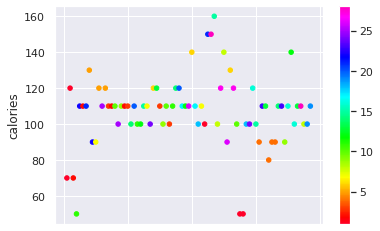

In [57]:
chameleon_cluster = Chameleon()
# returns a pands.dataframe of cluster
res = chameleon_cluster.cluster(df, 2, knn=20, m=40, alpha=2.0, plot=False)
# draw a 2-D scatter plot with cluster
chameleon_cluster.plot2d_data(res)

# K medoid (Implementation)

In [16]:
def kMedoids(D, k, tmax=100):
    # determine dimensions of distance matrix D
    m, n = D.shape

    if k > n:
        raise Exception('too many medoids')

    # find a set of valid initial cluster medoid indices since we
    # can't seed different clusters with two points at the same location
    valid_medoid_inds = set(range(n))
    invalid_medoid_inds = set([])
    rs,cs = np.where(D==0)
    # the rows, cols must be shuffled because we will keep the first duplicate below
    index_shuf = list(range(len(rs)))
    np.random.shuffle(index_shuf)
    rs = rs[index_shuf]
    cs = cs[index_shuf]
    for r,c in zip(rs,cs):
        # if there are two points with a distance of 0...
        # keep the first one for cluster init
        if r < c and r not in invalid_medoid_inds:
            invalid_medoid_inds.add(c)
    valid_medoid_inds = list(valid_medoid_inds - invalid_medoid_inds)

    if k > len(valid_medoid_inds):
        raise Exception('too many medoids (after removing {} duplicate points)'.format(
            len(invalid_medoid_inds)))

    # randomly initialize an array of k medoid indices
    M = np.array(valid_medoid_inds)
    np.random.shuffle(M)
    M = np.sort(M[:k])

    # create a copy of the array of medoid indices
    Mnew = np.copy(M)

    # initialize a dictionary to represent clusters
    C = {}
    for t in range(tmax):
        # determine clusters, i. e. arrays of data indices
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
        # update cluster medoids
        for kappa in range(k):
            J = np.mean(D[np.ix_(C[kappa],C[kappa])],axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)
        # check for convergence
        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)
    else:
        # final update of cluster memberships
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

    # return results
    return M, C

read data from csv

In [45]:
df = pd.read_csv('cereal.csv')
data_array = np.array(df[['calories','sodium']])

No handles with labels found to put in legend.


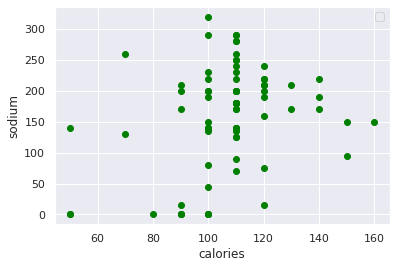

In [46]:
# plot data
plt.scatter(df.calories,df['sodium'],color='green')
plt.xlabel('calories')
plt.ylabel('sodium')
plt.legend()

In [62]:
# Apply algorithm
# distance matrix
D = pairwise_distances(data_array, metric='euclidean')

# split into 3 clusters
M, C = kMedoids(D, 3)
dict_of_result = {} # store result
print('medoids:')
for point_idx in M:
    print(data_array[point_idx] )

print('')
print('clustering result:')
for label in C:
    for point_idx in C[label]:
        print('label {0}:　{1}'.format(label, data_array[point_idx]))
        dict_of_result[label] = data_array[point_idx]

medoids:
[110 180]
[110 280]
[90 15]

clustering result:
label 0:　[ 70 130]
label 0:　[ 50 140]
label 0:　[110 200]
label 0:　[110 180]
label 0:　[110 125]
label 0:　[130 210]
label 0:　[ 90 200]
label 0:　[ 90 210]
label 0:　[120 220]
label 0:　[120 210]
label 0:　[110 140]
label 0:　[110 180]
label 0:　[110 180]
label 0:　[110 140]
label 0:　[110 220]
label 0:　[100 140]
label 0:　[100 190]
label 0:　[110 125]
label 0:　[110 200]
label 0:　[120 160]
label 0:　[110 135]
label 0:　[100 140]
label 0:　[110 170]
label 0:　[120 220]
label 0:　[110 180]
label 0:　[110 170]
label 0:　[140 170]
label 0:　[100 150]
label 0:　[110 180]
label 0:　[150  95]
label 0:　[150 150]
label 0:　[160 150]
label 0:　[100 220]
label 0:　[120 190]
label 0:　[140 220]
label 0:　[ 90 170]
label 0:　[130 170]
label 0:　[120 200]
label 0:　[100 135]
label 0:　[120 210]
label 0:　[100 140]
label 0:　[110 230]
label 0:　[110 200]
label 0:　[140 190]
label 0:　[100 200]
label 0:　[110 140]
label 0:　[100 230]
label 0:　[100 200]
label 0:　[110 200]
label 1:　[ 7

# AGNES (Implementation)

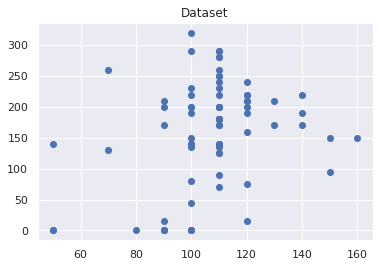

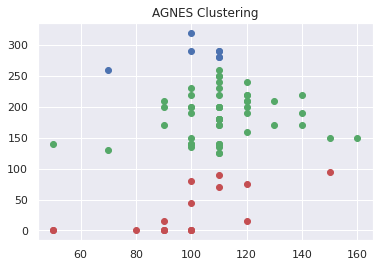

In [48]:
data = '''
1,70,130,
2,120,15,
3,70,260,
4,50,140,
5,110,200,
6,110,180,
7,110,125,
8,130,210,
9,90,200,
10,90,210,
11,120,220,
12,110,290,
13,120,210,
14,110,140,
15,110,180,
16,110,280,
17,100,290,
18,110,90,
19,110,180,
20,110,140,
21,100,80,
22,110,220,
23,100,140,
24,100,190,
25,110,125,
26,110,200,
27,100,0,
28,120,160,
29,120,240,
30,110,135,
31,100,45,
32,110,280,
33,100,140,
34,110,170,
35,120,75,
36,120,220,
37,110,250,
38,110,180,
39,110,170,
40,140,170,
41,110,260,
42,100,150,
43,110,180,
44,100,0,
45,150,95,
46,150,150,
47,160,150,
48,100,220,
49,120,190,
50,140,220,
51,90,170,
52,130,170,
53,120,200,
54,100,320,
55,50,0,
56,50,0,
57,100,135,
58,100,0,
59,120,210,
60,100,140,
61,90,0,
62,110,240,
63,110,290,
64,80,0,
65,90,0,
66,90,0,
67,110,70,
68,110,230,
69,90,15,
70,110,200,
71,140,190,
72,100,200,
73,110,250,
74,110,140,
75,100,230,
76,100,200,
77,110,200,
'''

# Load data set

def load_dataset(data):
    data_   = data.strip().split(',')
    dataset = [(float(data_[i]), float(data_[i+1])) for i in range(1, len(data_)-1, 3)]
    return dataset

def show_dataset(dataset):
    for item in dataset:
        plt.plot(item[0], item[1], 'ob')
    plt.title("Dataset")
    plt.show()


# Calculate the Euclidean distance between two points and return

def elu_distance(a, b):
    dist = np.sqrt(np.sum(np.square(np.array(a) - np.array(b))))
    return dist

# Calculate the minimum distance between Ci, Cj and return

def dist_min(ci, cj):
    return min(elu_distance(i, j) for i in ci for j in cj)



# Calculate the maximum distance between Ci, Cj and return

def dist_max(ci, cj):
    return max(elu_distance(i, j) for i in ci for j in cj)



# Calculate the average distance between the set Ci, Cj and return

def dist_avg(ci, cj):
    return sum(elu_distance(i, j) for i in ci for j in cj) / (len(ci) * len(cj))

# Find the two clusters with the smallest distance and return

def find_index(m):
    min_dist = float('inf')
    x = y = 0
    for i in range(len(m)):
        for j in range(len(m[i])):
            if i != j and m[i][j] < min_dist:
                min_dist, x, y = m[i][j], i, j
    return x, y, min_dist




# AGNES Algorithm: Hierarchical clustering algorithm of "bottom-up" aggregation strategy
# 1. Use each sample in the data set as an initial cluster
# 2. Find the closest two clusters and merge them
# 3. Repeat step 2 continuously until the preset number of clusters is reached 


def agnes(dataset, dist, k):
   # Initialize cluster clusters and distance matrix
    c, m = [], []
  # Use each sample in the data set as an initial cluster
    for item in dataset:
        ci = []
        ci.append(item)
        c.append(ci)
    # Calculate the distance between clusters based on a certain distance calculation method between sets
    for i in c:
        mi = []
        for j in c:
            mi.append(dist(i, j))
        m.append(mi)
    q = len(dataset)

    # Bottom-up" aggregation
    while q > k:
        # Find the two closest clusters to merge
        x, y, min_dist = find_index(m)
        c[x].extend(c[y])
        # Update clusters
        c.remove(c[y])
        # Recalculate the distance between clusters
        m = []
        for i in c:
            mi = []
            for j in c:
                mi.append(dist(i, j))
            m.append(mi)
        q -= 1
    return c

# Show clustering results

def show_cluster(cluster):
    # Show clustering results
    colors = ['or', 'ob', 'og', 'ok', 'oy', 'ow']
    for i in range(len(cluster)):
        for item in cluster[i]:
            plt.plot(item[0], item[1], colors[i])
    plt.title("AGNES Clustering")
    plt.show()
    

if __name__ == "__main__":
    dataset = load_dataset(data)
    show_dataset(dataset)
    k = 3
    cluster = agnes(dataset, dist_avg, k)
    show_cluster(cluster)
   

# DBSCAN (Implementation)

In [49]:
data = '''
1,70,130,
2,120,15,
3,70,260,
4,50,140,
5,110,200,
6,110,180,
7,110,125,
8,130,210,
9,90,200,
10,90,210,
11,120,220,
12,110,290,
13,120,210,
14,110,140,
15,110,180,
16,110,280,
17,100,290,
18,110,90,
19,110,180,
20,110,140,
21,100,80,
22,110,220,
23,100,140,
24,100,190,
25,110,125,
26,110,200,
27,100,0,
28,120,160,
29,120,240,
30,110,135,
31,100,45,
32,110,280,
33,100,140,
34,110,170,
35,120,75,
36,120,220,
37,110,250,
38,110,180,
39,110,170,
40,140,170,
41,110,260,
42,100,150,
43,110,180,
44,100,0,
45,150,95,
46,150,150,
47,160,150,
48,100,220,
49,120,190,
50,140,220,
51,90,170,
52,130,170,
53,120,200,
54,100,320,
55,50,0,
56,50,0,
57,100,135,
58,100,0,
59,120,210,
60,100,140,
61,90,0,
62,110,240,
63,110,290,
64,80,0,
65,90,0,
66,90,0,
67,110,70,
68,110,230,
69,90,15,
70,110,200,
71,140,190,
72,100,200,
73,110,250,
74,110,140,
75,100,230,
76,100,200,
77,110,200,
'''

def load_dataset(data):
    data_   = data.strip().split(',')
    dataset = [(float(data_[i]), float(data_[i+1])) for i in range(1, len(data_)-1, 3)]
    return dataset

# Show the data set distribution before clustering 

def show_dataset(dataset):
    for item in dataset:
        plt.plot(item[0], item[1], 'ob')
    plt.title("Dataset")
    plt.show()

def elu_distance(a, b):
    dist = np.sqrt(np.sum(np.square(np.array(a) - np.array(b))))
    return dist



# DBSCAN algorithm: 
# Derive the maximum density connected sample set based on the density reachability relationship
# 1. Find all core objects according to the given neighborhood parameters (e, min_points)
# 2. Taking any core object as the starting point, find out the density of the samples to generate clusters
# 3. Stop running when all core objects have been accessed 

def dbscan(dataset, e, min_points):
    # Number of clusters 
    k  = 0
    # Core object collection
    omega  = set()
    # Sample collection not visited 
    not_visit = set(dataset)
    # Clustering results
    cluster = dict()

    # Traverse the sample set to find all core objects 
    for di in dataset:
        if len([dj for dj in dataset if elu_distance(di, dj) <= e]) >= min_points:
            omega.add(di)

    while len(omega):
        # Record the sample collection currently not visited 
        not_visit_old = not_visit
        # Randomly select a core object core 
        core = list(omega)[random.randint(0, len(omega)-1)]
        not_visit  = not_visit - set(core)
        # Initialize the queue, store core objects or samples 
        core_deque = []
        core_deque.append(core)


        while len(core_deque):
            coreq = core_deque[0]
            # Find sample points in the neighborhood of coreq
            coreq_neighborhood = [di for di in dataset if elu_distance(di, coreq) <= e]

            # If coreq is the core object, find the unvisited samples in its neighborhood by intersection method 
            if len(coreq_neighborhood) >= min_points:
                intersection = not_visit & set(coreq_neighborhood)
                core_deque  += list(intersection)
                not_visit    = not_visit - intersection

            core_deque.remove(coreq)

        k += 1
        Ck = not_visit_old - not_visit
        omega = omega - Ck
        cluster[k] = list(Ck)
    return cluster

def show_cluster(cluster):
    colors = ['or', 'ob', 'og', 'ok', 'oy', 'ow']
    for key in cluster.keys():
        for item in cluster[key]:
            plt.plot(item[0], item[1], colors[key])
    plt.title("DBSCAN Clustering")
    plt.show()


    

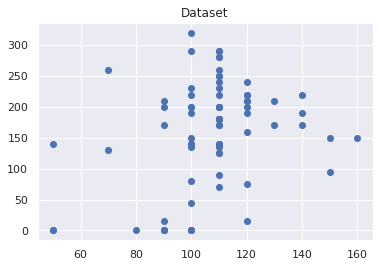

{1: [(120.0, 190.0), (110.0, 230.0), (140.0, 190.0), (90.0, 170.0), (120.0, 160.0), (110.0, 200.0), (110.0, 125.0), (120.0, 200.0), (110.0, 240.0), (100.0, 230.0), (100.0, 200.0), (120.0, 240.0), (110.0, 280.0), (130.0, 170.0), (90.0, 200.0), (110.0, 170.0), (120.0, 210.0), (130.0, 210.0), (110.0, 135.0), (110.0, 140.0), (110.0, 250.0), (100.0, 290.0), (110.0, 180.0), (110.0, 290.0), (140.0, 170.0), (90.0, 210.0), (110.0, 220.0), (160.0, 150.0), (100.0, 220.0), (100.0, 135.0), (120.0, 220.0), (150.0, 150.0), (110.0, 260.0), (100.0, 140.0), (100.0, 150.0), (140.0, 220.0), (100.0, 190.0)], 2: [(90.0, 15.0), (90.0, 0.0), (120.0, 15.0), (80.0, 0.0), (100.0, 0.0)], 3: [(110.0, 90.0), (120.0, 75.0), (110.0, 70.0), (100.0, 80.0)]}
dict_keys([1, 2, 3])


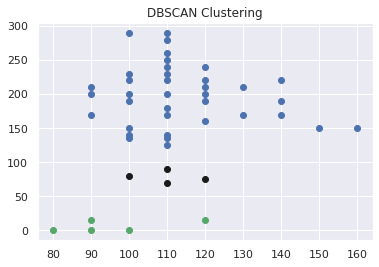

In [50]:
dataset = load_dataset(data)
show_dataset(dataset)
# e, min_points = 0.11, 5
e, min_points = 25, 3 # change to 10,20,30,25
cluster = dbscan(dataset, e, min_points)
print(cluster)
print(cluster.keys())
show_cluster(cluster)
